In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# read input

In [3]:
file = pd.read_csv('/Users/xx24/Documents/PhD/Course/ATMS523-Weather Data Analysis/machine-learning-1-Jim-Xu/homework/radar_parameters.csv', skiprows=1, header=None)
file.columns = ["number" ,"Zh (dBZ)","Zdr (dB)","Ldr (dB)","Kdp (deg km-1)","Ah (dBZ/km)","Adr (dB/km)","R (mm/hr)"]
file = file.drop(['number'], axis=1)

# add baseline

In [4]:
file['R_bl'] = (10**(file['Zh (dBZ)']/10)/200)**(1/1.6)
file

,Zh (dBZ),Zdr (dB),Ldr (dB),Kdp (deg km-1),Ah (dBZ/km),Adr (dB/km),R (mm/hr),R_bl
0,23.144878,0.418637,-41.757733,0.005395,0.000290,0.000012,2.393520,1.019556
1,22.737156,0.322850,-43.772069,0.005194,0.000360,0.000012,3.502699,0.961454
2,26.869826,0.330948,-43.577399,0.013385,0.000903,0.000030,8.627561,1.742691
3,28.540561,0.399480,-42.139731,0.018872,0.001036,0.000043,8.424447,2.216365
4,30.500127,0.543758,-39.763087,0.027438,0.001157,0.000064,8.189291,2.938422
...,...,...,...,...,...,...,...,...
18964,31.515997,0.579955,-39.244229,0.034048,0.001417,0.000080,10.648020,3.400996
18965,29.993334,0.567935,-39.399188,0.024134,0.001032,0.000057,7.981875,2.731742
18966,31.685913,0.655681,-38.375696,0.033971,0.001165,0.000081,6.822691,3.485185
18967,32.980096,0.768586,-37.166218,0.043117,0.001285,0.000105,6.801169,4.198675


In [5]:
X = file.drop(['R (mm/hr)', 'R_bl'], axis=1)
y = pd.DataFrame(file['R (mm/hr)'])
y_bl = pd.DataFrame(file['R_bl'])

# train data

In [6]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,test_size=0.3, train_size=0.7, random_state=0)

# linear regression 

In [7]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression(fit_intercept=True)
lr_model.fit(Xtrain, ytrain)
lr_y = lr_model.predict(Xtest)

In [8]:
from sklearn.metrics import r2_score, mean_squared_error
lr_train_r2 = r2_score(ytest, lr_y)
lr_train_rmse = mean_squared_error(ytest, lr_y, squared=False)
print("R2 = "+str(lr_train_r2))
print("RMS = "+str(lr_train_rmse))

R2 = 0.9868599917483049
RMS = 0.9583564653829768


# polynominal regression

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

param_grid = {'polynomialfeatures__degree': np.arange(10), #21 took too long time
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

In [15]:
grid.fit(Xtrain, ytrain)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'linearregression__fit_intercept': [True, False],
                         'linearregression__normalize': [True, False],
                         'polynomialfeatures__degree': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [16]:
grid.best_params_

{'linearregression__fit_intercept': True,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 2}

In [17]:
gs_model = grid.best_estimator_
gs_y = gs_model.predict(Xtest)

gs_train_r2 = r2_score(ytest, gs_y)
gs_train_rmse = mean_squared_error(ytest, gs_y, squared=False)
print("R2 = "+str(gs_train_r2))
print("RMS = "+str(gs_train_rmse))

R2 = 0.9994339502731633
RMS = 0.19890996944908407


# random forest regression

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

rf_gs = {'bootstrap': [True, False],  
         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],  
         'max_features': ['auto', 'sqrt'],  
         'min_samples_leaf': [1, 2, 4],  
         'min_samples_split': [2, 5, 10],  
         'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
         
rf = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = rf_gs, n_iter = 100, cv = 7, verbose=2, random_state=42, n_jobs = -1)

In [21]:
rf.fit(Xtrain, ytrain)

Fitting 7 folds for each of 100 candidates, totalling 700 fits


/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=7, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [22]:
rf_y = rf.predict(Xtest)

rf_y_r2 = r2_score(ytest, rf_y)
rf_y_rmse = mean_squared_error(ytest, rf_y, squared=False)
print("R2 = "+str(rf_y_r2))
print("RMS = "+str(rf_y_rmse))

R2 = 0.9473881806031488
RMS = 1.9176569484937949


# comparison of model

Text(0.5, 1.0, 'Random Forest Regressor')

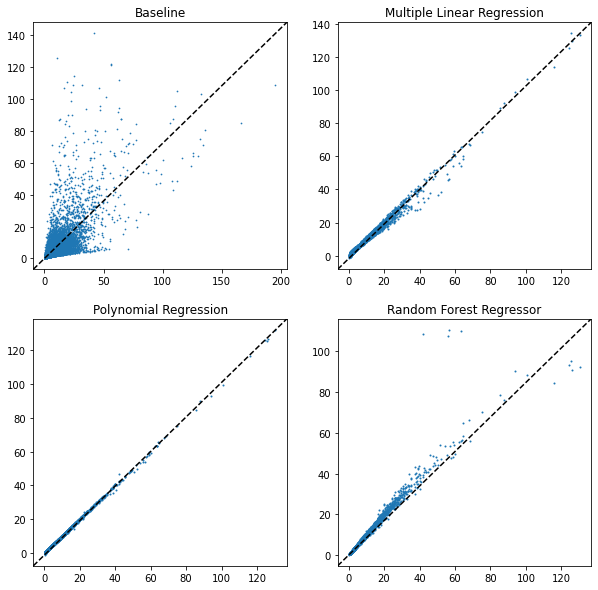

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

axes[0, 0].scatter(y, file['R_bl'], s=0.5)
axes[0, 1].scatter(ytest, lr_y, s=1)
axes[1, 0].scatter(ytest, gs_y, s=1)
axes[1, 1].scatter(ytest, rf_y, s=1)

axes[0, 0].plot((0, 1), (0, 1), transform=axes[0, 0].transAxes, ls='--',c='k', label="1:1 line")
axes[0, 1].plot((0, 1), (0, 1), transform=axes[0, 1].transAxes, ls='--',c='k', label="1:1 line")
axes[1, 0].plot((0, 1), (0, 1), transform=axes[1, 0].transAxes, ls='--',c='k', label="1:1 line")
axes[1, 1].plot((0, 1), (0, 1), transform=axes[1, 1].transAxes, ls='--',c='k', label="1:1 line")

axes[0, 0].set_title("Baseline")
axes[0, 1].set_title("Multiple Linear Regression")
axes[1, 0].set_title("Polynomial Regression")
axes[1, 1].set_title("Random Forest Regressor")